In [32]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import cv2
import matplotlib.pyplot as plt

In [11]:
def add_noise (image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not open or find the image '{image_path}'")
    else:
        # Define blur parameters (adjust sigmaX and sigmaY for different blur effects)
        blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=3, sigmaY=3)

        # Add noise
        noise = np.random.normal(loc=0, scale=15, size=image.shape)
        noisy_image = np.clip(blurred + noise, 0, 255).astype(np.uint8)

        # Create a copy for scratches
        image_with_scratches = np.copy(noisy_image)

        # Adding realistic scratches
        for _ in range (np.random.randint (50, 70)):  # Adjust the number of scratches as needed
            x1, y1 = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])
            angle = np.random.randint(0, 180)
            length = np.random.randint(100, 1000)  # Adjusted range for scratch length
            thickness = np.random.randint(1, 5)  # Adjusted range for scratch thickness
            color = (np.random.randint(200, 256), np.random.randint(200, 256), np.random.randint(200, 256))

            x2 = int(x1 + length * np.cos(np.deg2rad(angle)))
            y2 = int(y1 + length * np.sin(np.deg2rad(angle)))
            
            # Simulate irregularities in the scratch path
            num_segments = np.random.randint(2, 5)  # Vary the number of segments in the scratch path
            points = [(x1, y1)]
            for _ in range(num_segments):
                delta_x = np.random.randint(-5, 6)  # Random deviation in x-direction
                delta_y = np.random.randint(-5, 6)  # Random deviation in y-direction
                x_next = points[-1][0] + delta_x
                y_next = points[-1][1] + delta_y
                points.append((x_next, y_next))

            # Convert points to numpy array and draw the scratch
            points = np.array(points, dtype=np.int32)
            cv2.polylines(noisy_image, [points], isClosed=False, color=color, thickness=thickness)

        return noisy_image

In [4]:
high_path = os.path.join ('DIV2KMerged', 'high')
low_path = os.path.join ('DIV2KMerged', 'low')

In [5]:
def generate_low_res_images ():
    for image in os.listdir (high_path):
        noise_image = add_noise (os.path.join (high_path, image))
        cv2.imwrite (os.path.join (low_path, image), noise_image)
        
# generate_low_res_images ()

In [6]:
len (os.listdir (high_path)), len (os.listdir (low_path))

(800, 800)

In [12]:
class LowHighResDataset (Dataset):
    def __init__ (self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.lows_path = os.path.join (self.dataset_path, 'low')
        self.highs_path = os.path.join (self.dataset_path, 'high')
        self.lows = os.listdir (self.lows_path)
        self.highs = os.listdir (self.highs_path)
        
    def __len__ (self):
        return len (self.highs)
    
    def __getitem__ (self, ix):
        low_path_item = self.lows[ix]
        high_path_item = self.highs[ix]
        
        low_path = os.path.join (self.lows_path, low_path_item)
        high_path = os.path.join (self.highs_path, high_path_item)
        
        low = Image.open (low_path).convert ('RGB')
        high = Image.open (high_path).convert ('RGB')
        
        if self.transform:
            low = self.transform (low)
            high = self.transform (high)
            
        return low, high

In [13]:
transform = transforms.Compose ([
    transforms.Resize ((720, 1280), antialias=True),
    transforms.ToTensor ()
])

In [14]:
dataset = LowHighResDataset ('./DIV2KMerged', transform=transform)

In [15]:
train_size = int (0.8 * len (dataset))
test_size = len (dataset) - train_size

In [16]:
train_dataset, test_dataset = random_split (dataset, [train_size, test_size])

In [23]:
train = DataLoader (train_dataset, batch_size=32, shuffle=True)
test = DataLoader (test_dataset, batch_size=32, shuffle=False)

In [24]:
a, b = next (iter (train))

Text(0.5, 1.0, 'High-Res Image')

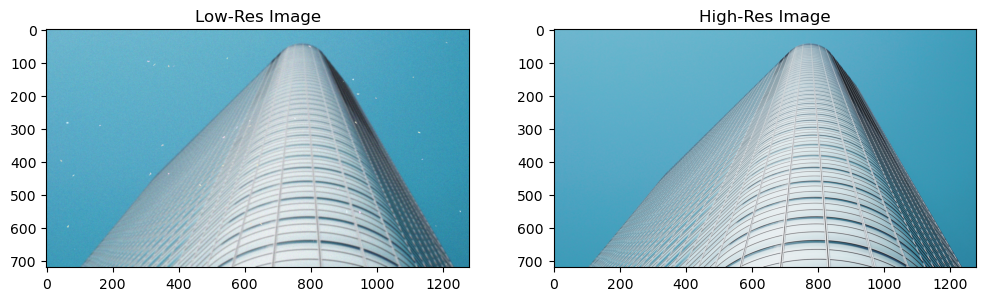

In [25]:
plt.figure (figsize=(12, 5))
plt.subplot (1, 2, 1)
plt.imshow (a[3, :].permute (1, 2, 0))
plt.title ('Low-Res Image')
plt.subplot (1, 2, 2)
plt.imshow (b[3, :].permute (1, 2, 0))
plt.title ('High-Res Image')

In [40]:
H, W = 720, 1280

In [41]:
for i in range (10, 200):
    if H % i == 0 and W % i == 0:
        print (i, end=' ')

10 16 20 40 80 

In [42]:
P = 80

In [43]:
N = (H * W) // (P ** 2)
N

144

In [27]:
img = a[3, :].clone ()

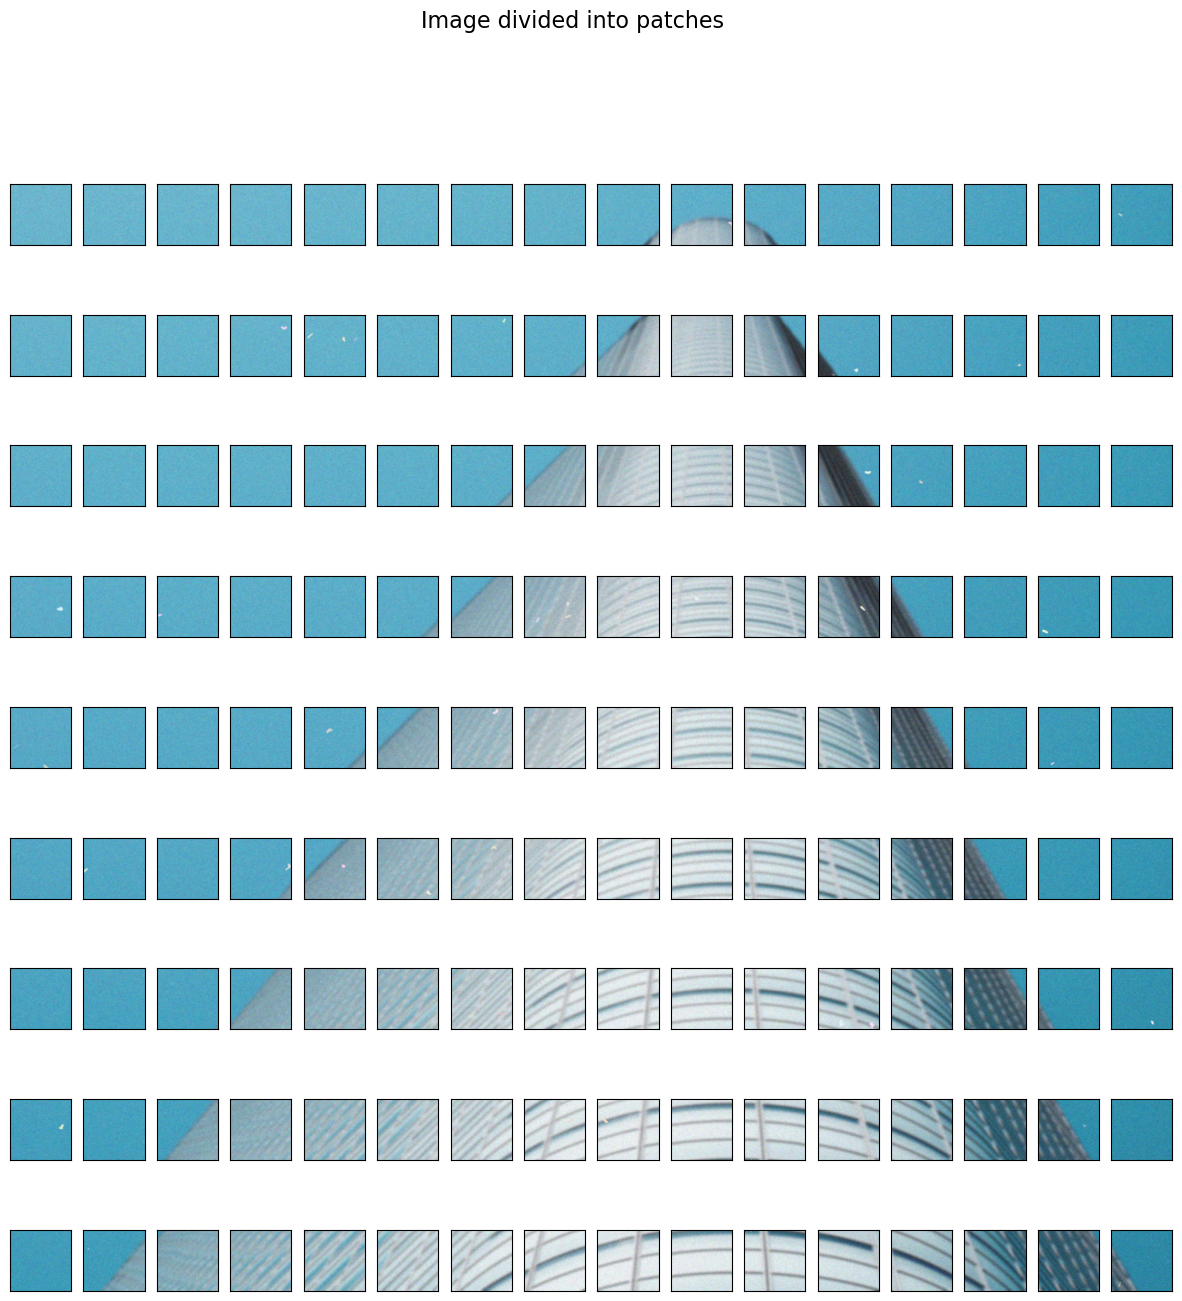

In [28]:
# Given dimensions
H, W = 720, 1280
patch_size = 80
assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of subplots
fig, axs = plt.subplots(nrows=H // patch_size, 
                        ncols=W // patch_size,
                        figsize=(15, 15),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image to plot patches
for i, patch_height in enumerate(range(0, H, patch_size)):
    for j, patch_width in enumerate(range(0, W, patch_size)):
        # Extract patch from image tensor
        patch = img[:, patch_height:patch_height+patch_size, patch_width:patch_width+patch_size]
        
        # Convert torch tensor to numpy array for plotting
        patch_np = patch.permute(1, 2, 0).cpu().numpy()  # Assuming CPU and channels last format
        
        # Plot the patch
        axs[i, j].imshow(patch_np)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle("Image divided into patches", fontsize=16)
plt.show()

# testing forward with low, high

In [177]:
dim = 1024
mlp_dim = 4096

In [191]:
a_unfolded = a.unfold(2, P, P).unfold(3, P, P)
a_unfolded.shape

torch.Size([32, 3, 9, 16, 80, 80])

In [196]:
a_contiguous = a_unfolded.contiguous ().view (32, 3, -1, P * P)
a_contiguous.shape

torch.Size([32, 3, 144, 6400])

In [199]:
a_permuted = a_contiguous.permute(0, 2, 1, 3).contiguous().view(32, -1, P)
a_permuted.shape

torch.Size([32, 34560, 80])

In [34]:
lr_image = a.clone ()
hr_image = b.clone ()

In [36]:
lr_image.shape, hr_image.shape

(torch.Size([32, 3, 720, 1280]), torch.Size([32, 3, 720, 1280]))

In [ ]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * (avg_out + max_out)

class RCAB(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction=16):
        super(RCAB, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(n_feat, n_feat // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(n_feat // reduction, n_feat, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return x * (avg_out + max_out)

class ResidualGroup(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = [RCAB(n_feat, kernel_size, reduction) for _ in range(n_resblocks)]
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, padding=(kernel_size//2)))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        return res + x

class RCAN(nn.Module):
    def __init__(self, n_resgroups, n_resblocks, n_feats, reduction, scale, n_colors, kernel_size=3):
        super(RCAN, self).__init__()
        modules_head = [nn.Conv2d(n_colors, n_feats, kernel_size, padding=(kernel_size//2))]
        modules_body = [ResidualGroup(n_feats, kernel_size, reduction, nn.ReLU(True), n_resblocks) for _ in range(n_resgroups)]
        modules_body.append(nn.Conv2d(n_feats, n_feats, kernel_size, padding=(kernel_size//2)))
        modules_tail = [
            nn.Conv2d(n_feats, n_feats * (scale ** 2), kernel_size, padding=(kernel_size//2)),
            nn.PixelShuffle(scale),
            nn.Conv2d(n_feats, n_colors, kernel_size, padding=(kernel_size//2))
        ]
        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
        return x

# Example usage:

device = torch.device ('mps')
model = RCAN (n_resgroups=10, n_resblocks=20, n_feats=64, reduction=16, scale=4, n_colors=3)
model = model.to (device)
input = torch.randn (1, 3, 720, 1280).to (device)
output = model(input)
print(output.shape)

In [98]:
ypred.shape, ytrue.shape

NameError: name 'ypred' is not defined

Text(0.5, 1.0, 'residual - ytrue')

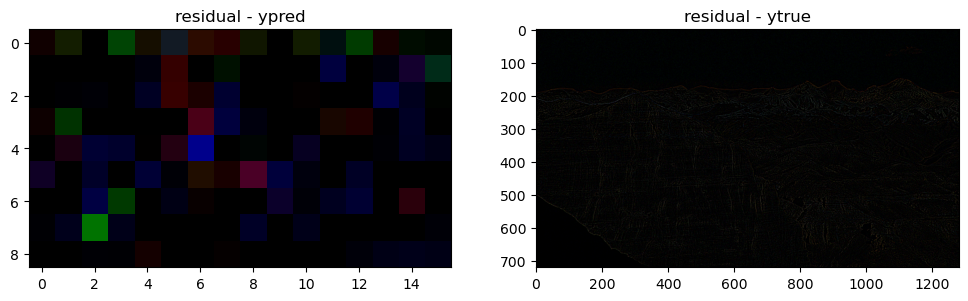

In [76]:
plt.figure (figsize=(12, 5))
plt.subplot (1, 2, 1)
plt.imshow (ypred[0, :].permute (1, 2, 0).detach ().numpy ().clip (0, 255))
plt.title ('residual - ypred')
plt.subplot (1, 2, 2)
plt.imshow (ytrue[0, :].permute (1, 2, 0).detach ().numpy ().clip (0, 255))
plt.title ('residual - ytrue')

In [2]:
from datasets import load_dataset

ds = load_dataset ("MattCoddity/dockerNLcommands")

In [11]:
from datasets import 